In [662]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fuzzywuzzy as fuzz
from fuzzywuzzy import process

# Load the data CSVs

In [663]:
# load full_output.csv
df = pd.read_csv('full_output.csv')
df.columns = df.columns.str.strip()
# drop event column
df = df.drop(columns=['Event', 'TEA'])
print(len(df))

# load pml_output.csv
pml_df = pd.read_csv('pml_output.csv')
pml_df.columns = pml_df.columns.str.strip()
# drop the event column
pml_df = pml_df.drop(columns=['Event Name'])
print(len(pml_df))


60669
1318


# Remove disqualified and null rows

In [664]:
# Remove DNA, DQ
judging_columns = ['Stage Judge 1', 'Stage Judge 2', 'Stage Judge 3', 'Stage Final', 'SR Judge 1', 'SR Judge 2', 'SR Judge 3', 'SR Final']
for i in judging_columns:
    df = df[df[i] != 'DNA']
    df = df[df[i] != 'DQ']

print(len(df))

60141


In [665]:
# remove rows with blank judges values
# repla
for i in judging_columns:
    df = df[df[i] != ' ']


In [666]:
# trim whitespace from selections
df['Selection 1'] = df['Selection 1'].str.strip()
df['Selection 2'] = df['Selection 2'].str.strip()
df['Selection 3'] = df['Selection 3'].str.strip()

# Trim whitespace from classification column
df['Classification'] = df['Classification'].str.strip()

# Eliminate double spaces from selections
df['Selection 1'] = df['Selection 1'].str.replace('  ', ' ')
df['Selection 2'] = df['Selection 2'].str.replace('  ', ' ')
df['Selection 3'] = df['Selection 3'].str.replace('  ', ' ')

## Get the average judge rating

In [667]:
# set judging data to integer
df['Stage Judge 1'] = df['Stage Judge 1'].astype(int)
df['Stage Judge 2'] = df['Stage Judge 2'].astype(int)
df['Stage Judge 3'] = df['Stage Judge 3'].astype(int)
df['Stage Final'] = df['Stage Final'].astype(int)
df['SR Judge 1'] = df['SR Judge 1'].astype(int)
df['SR Judge 2'] = df['SR Judge 2'].astype(int)
df['SR Judge 3'] = df['SR Judge 3'].astype(int)
df['SR Final'] = df['SR Final'].astype(int)

In [668]:
# Average together Stage Judge 1, 2, and 3 into a new column
df['Stage Average'] = (df['Stage Judge 1'] + df['Stage Judge 2'] + df['Stage Judge 3']) / 3

In [669]:
def top_n_grabber(n, df):
    # Select all 'Selection 1' rows as a list
    selection_1_list = df['Selection 1'].tolist()
    # Select all 'Selection 2' rows
    selection_2_list = df['Selection 2'].tolist()
    # Select all 'Selection 3' rows
    selection_3_list = df['Selection 3'].tolist()
    # combine selection 1, 2, and 3 into one list
    full_selection_list = pd.DataFrame(selection_1_list + selection_2_list + selection_3_list)

    top_20_df = pd.DataFrame(full_selection_list.value_counts()[:n])
    top_20_df.columns = ['Count']
    top_20_df.reset_index(drop=False, inplace=True)
    top_20_df.columns = ['Selection', 'Count']
    top_20_df

    # make selection column into a list
    selection_list = top_20_df['Selection'].tolist()
    value_list = top_20_df['Count'].tolist()
    return selection_list, value_list

In [670]:
# Clean the data 
selection_columns = ['Selection 1', 'Selection 2', 'Selection 3']

for column in selection_columns:
    ''' 
    df[column] = df[column].str.replace('/ ', '', regex=False)
    df[column] = df[column].str.replace(' (play all)', '', regex=False)
    df[column] = df[column].str.replace('Dallas F. Bayless', 'Bayless', regex=False)
    df[column] = df[column].str.replace('Dallas Bayless', 'Bayless', regex=False)
    df[column] = df[column].str.replace('/)', ')', regex=False)
    df[column] = df[column].str.replace('Sean O\'Loughlin', 'O\'Loughlin', regex=False)
    df[column] = df[column].str.replace('Claude Smith', 'Smith', regex=False)
    df[column] = df[column].str.replace('Claude T. Smith', 'Smith', regex=False)
    df[column] = df[column].str.replace('Claude Smith', 'Smith', regex=False)
    df[column] = df[column].str.replace('Smith, Claude T.', 'Smith', regex=False)
    df[column] = df[column].str.replace('Edmundson', 'Edmondson', regex=False)
    df[column] = df[column].str.replace('\"', '', regex=False)
    df[column] = df[column].str.replace('David Maslanka', 'Maslanka', regex=False)
    df[column] = df[column].str.replace('Marquez/Nickel', 'Marquez', regex=False)
    df[column] = df[column].str.replace('Grainger/Rogers/SMC', 'Grainger', regex=False)
    df[column] = df[column].str.replace('Bernstein/Grundman or Beeler', 'Bernstein', regex=False)
    df[column] = df[column].str.replace('Bernstein/Grundman', 'Bernstein', regex=False)
    df[column] = df[column].str.replace('Bernstein/Grundman/HL Beeler/GS(POP)', 'Bernstein', regex=False)
    df[column] = df[column].str.replace('Bernstein/Grundman/Beeler', 'Bernstein', regex=False)
    df[column] = df[column].str.replace('Bernstein/Beeler', 'Bernstein', regex=False)
    df[column] = df[column].str.replace(' (457)', '', regex=False)
    df[column] = df[column].str.replace('Samuel Hazo', 'Hazo', regex=False)
    df[column] = df[column].str.replace('Sam Hazo', 'Hazo', regex=False)
    df[column] = df[column].str.replace('Bernstein ', 'Bernstein', regex=False)
    df[column] = df[column].str.replace('Bernstein Grundman', 'Bernstein', regex=False)
    df[column] = df[column].str.replace('Candide (Grundman', 'Candide (Bernstein', regex=False)
    df[column] = df[column].str.replace('BernsteinGrundman', 'Bernstein', regex=False)
    df[column] = df[column].str.replace(' (15843)', '', regex=False)
    df[column] = df[column].str.replace('Hazo ', 'Hazo', regex=False)
    df[column] = df[column].str.replace(' (15853)', '', regex=False)
    df[column] = df[column].str.replace('Samuel R. Hazo', 'Hazo', regex=False)
    df[column] = df[column].str.replace('2 (Arturo Marquez Transcribed. by Oliver Nickel', '2 (Marquez', regex=False)
    df[column] = df[column].str.replace(' (17583)', '', regex=False)
    df[column] = df[column].str.replace('Arturo Marquez/arr. Oliver Nickel', 'Marquez', regex=False)
    df[column] = df[column].str.replace('Arturo Marquez/Oliver Nickel', 'Marquez', regex=False)
    df[column] = df[column].str.replace('/Nickel', '', regex=False)
    df[column] = df[column].str.replace('No 2', 'No. 2', regex=False)
    df[column] = df[column].str.replace('Marquez/Nickle', 'Marquez', regex=False)
    df[column] = df[column].str.replace('No.2', 'No. 2', regex=False)
    df[column] = df[column].str.replace('No.2', 'No. 2', regex=True)
    '''
    # remove all inside parenthesis
    df[column] = df[column].str.replace('\(.*\)', '', regex=True)
    # trim whitespace
    df[column] = df[column].str.strip()


In [691]:
# get different datasets
df_6a = df[df['Conference'] == 'AAAAAA']
df_6a_varsity = df[(df['Classification'] == 'Varsity') & (df['Conference'] == 'AAAAAA')]
df_6a_nonvarsity = df[(df['Classification'] == 'Non-Varsity') & (df['Conference'] == 'AAAAAA')]
df_6a_subnonvarsity = df[(df['Classification'].str.contains('Sub Non')) & (df['Conference'] == 'AAAAAA')]
df_5a = df[df['Conference'] == 'AAAAA']
df_5a_varsity = df[(df['Classification'] == 'Varsity') & (df['Conference'] == 'AAAAA')]
df_5a_nonvarsity = df[(df['Classification'] == 'Non-Varsity') & (df['Conference'] == 'AAAAA')]
df_5a_subnonvarsity = df[(df['Classification'].str.contains('Sub Non')) & (df['Conference'] == 'AAAAA')]
df_4a = df[df['Conference'] == 'AAAA']
df_4a_varsity = df[(df['Classification'] == 'Varsity') & (df['Conference'] == 'AAAA')]
df_4a_nonvarsity = df[(df['Classification'] == 'Non-Varsity') & (df['Conference'] == 'AAAA')]
df_4a_subnonvarsity = df[(df['Classification'].str.contains('Sub Non')) & (df['Conference'] == 'AAAA')]
df_3a = df[df['Conference'] == 'AAA']
df_3a_varsity = df[(df['Classification'] == 'Varsity') & (df['Conference'] == 'AAA')]
df_3a_nonvarsity = df[(df['Classification'] == 'Non-Varsity') & (df['Conference'] == 'AAA')]
df_3a_subnonvarsity = df[(df['Classification'].str.contains('Sub Non')) & (df['Conference'] == 'AAA')]
df_2a = df[df['Conference'] == 'AA']
df_2a_varsity = df[(df['Classification'] == 'Varsity') & (df['Conference'] == 'AA')]
df_2a_nonvarsity = df[(df['Classification'] == 'Non-Varsity') & (df['Conference'] == 'AA')]
df_2a_subnonvarsity = df[(df['Classification'].str.contains('Sub Non')) & (df['Conference'] == 'AA')]
df_1a = df[df['Conference'] == 'A']
df_1a_varsity = df[(df['Classification'] == 'Varsity') & (df['Conference'] == 'A')]
df_1a_nonvarsity = df[(df['Classification'] == 'Non-Varsity') & (df['Conference'] == 'A')]
df_1a_subnonvarsity = df[(df['Classification'].str.contains('Sub Non')) & (df['Conference'] == 'A')]
df_2005 = df[df['Year'] == 2005]
df_2006 = df[df['Year'] == 2006]
df_2007 = df[df['Year'] == 2007]
df_2008 = df[df['Year'] == 2008]
df_2009 = df[df['Year'] == 2009]
df_2010 = df[df['Year'] == 2010]
df_2011 = df[df['Year'] == 2011]
df_2012 = df[df['Year'] == 2012]
df_2013 = df[df['Year'] == 2013]
df_2014 = df[df['Year'] == 2014]
df_2015 = df[df['Year'] == 2015]
df_2016 = df[df['Year'] == 2016]
df_2017 = df[df['Year'] == 2017]
df_2018 = df[df['Year'] == 2018]
df_2019 = df[df['Year'] == 2019]
df_2020 = df[df['Year'] == 2020]
df_2021 = df[df['Year'] == 2021]
df_2022 = df[df['Year'] == 2022]

df_year_list = [df_2005, df_2006, df_2007, df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022]
year_list = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]



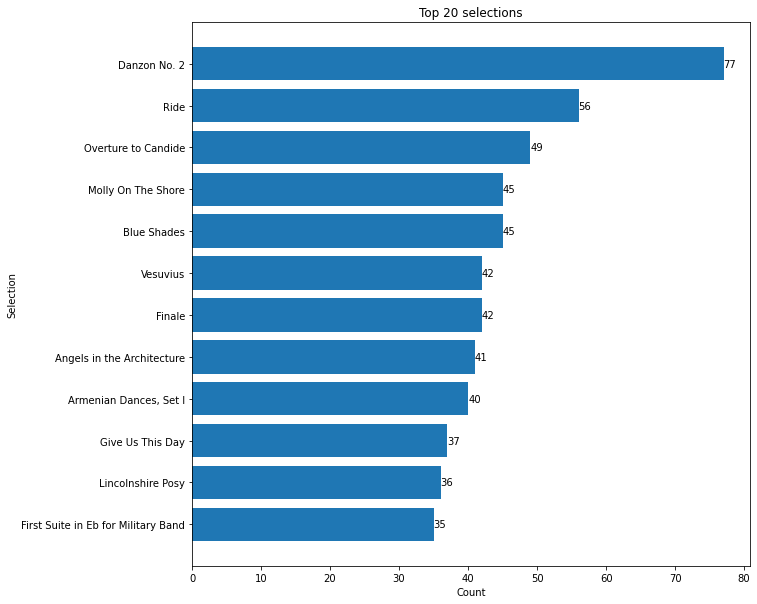

In [692]:
#plot top 20 selections
def plotter(n, df):
    fig, ax = plt.subplots()
    bars = ax.barh(top_n_grabber(n, df)[0], top_n_grabber(n, df)[1])
    ax.set_title(f'Top 20 selections')
    ax.set_xlabel('Count')
    ax.set_ylabel('Selection')
    for bars in ax.containers:
        ax.bar_label(bars)
    # invert the y-axis
    ax.invert_yaxis()
    # increase size of plot
    #plt.rcParams['figure.figsize'] = (10, 10)

    plt.show()

plotter(12, df_6a_varsity)

# Find Rows by Selection Title

In [693]:
# combine all rows where selection 1, 2, or 3 contains 'Overture to Candide'
def selection_finder(selection, df):
    finder_df = df[(df['Selection 1'].str.contains(selection)) | (df['Selection 2'].str.contains(selection)) | (df['Selection 3'].str.contains(selection))]
    return finder_df

selection = 'Trittico'
df_for_search = df_6a_varsity

selection_finder_df = selection_finder(selection, df_for_search)
selection_finder_df

,Unnamed: 0,School,City,Directors,Conference,Classification,Year,ID,Stage Judge 1,Stage Judge 2,...,Stage Final,SR Judge 1,SR Judge 2,SR Judge 3,SR Final,Award,Selection 1,Selection 2,Selection 3,Stage Average
36683,45929,Pearland High School,Pearland,"Joe Munoz / Beau Hunter, Gino Hernandez and N...",AAAAAA,Varsity,2016,115179,1,1,...,1,1,1,1,1,A,Trittico,The Flying Dutchman Overture,The Melody Shop March,1.0
36991,46740,The Woodlands College Park HS,The Woodlands,Charlotte Royall,AAAAAA,Varsity,2016,112316,1,1,...,1,1,1,1,1,A,March from Symphonic Metamorphosis,Lux Aurumque,Trittico,1.0
38754,47972,Leander High School,Leander,Robert Selaiden,AAAAAA,Varsity,2017,125929,1,1,...,1,1,1,1,1,A,Blue Shades,Trittico,The Rifle Regiment,1.0
41712,57709,Travis High School,Richmond,"Josafat Jaime / Jose Falcon, Tiffani Reynolds",AAAAAA,Varsity,2017,127765,1,1,...,1,1,1,1,1,A,El Gallito,Bell Piece,Trittico,1.0
41721,57701,Dulles High School,Sugar Land,"Joe Pruitt / Arnel Dayrit, Spencer Clayton",AAAAAA,Varsity,2017,127879,1,1,...,1,1,1,1,1,A,Jack Tar March,Trittico,Danzon No. 2,1.0
42862,58265,Bowie High School,Arlington,Rumaldo Solis,AAAAAA,Varsity,2018,135750,1,1,...,1,1,1,1,1,A,Glory of the Yankee Navy March,Trittico,Ave Maria,1.0
44229,49710,Harlingen South High School,Harlingen,Shane Shinsato,AAAAAA,Varsity,2018,133660,1,1,...,1,1,1,1,1,A,Athletic Festival March,Trittico,Mars,1.0
44437,49249,Katy High School,Katy,"Terence Gorton / Dale Fremin, Brannon Baker",AAAAAA,Varsity,2018,136707,1,1,...,1,1,1,1,1,A,Florentiner March,Trittico,Instinctive Travels,1.0
48072,50468,Ridge Point High School,Missouri City,"Luis Saldana / Gregory Davis, Christopher Banos",AAAAAA,Varsity,2019,150070,1,1,...,1,1,1,1,1,A,Courier Journal March,O Magnum Mysterium,Trittico,1.0
48334,50384,JJ Pearce HS,Richardson,Dimitrios Icossipentarhos,AAAAAA,Varsity,2019,148467,1,1,...,1,1,1,1,1,A,The Ringmaster's March,Danzon No. 2,Trittico,1.0


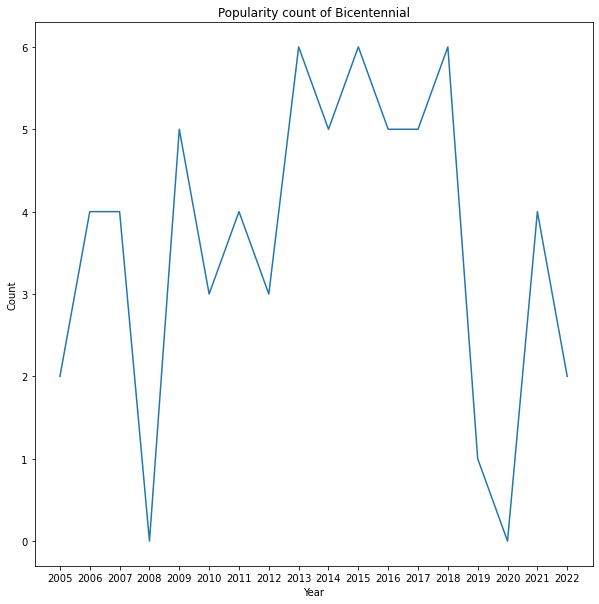

In [699]:
selection = 'Bicentennial'
yearly_count_values = []
for year in df_year_list:
    selection_finder_df = selection_finder(selection, year)
    yearly_count_values.append(len(selection_finder_df))

# make a line graph of the yearly count of selections
def yearly_count_plotter(yearly_count_values):
    fig, ax = plt.subplots()
    ax.plot(yearly_count_values)
    ax.set_title(f'Popularity count of {selection}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    # set number of ticks on x-axis to match len(year_list)
    ax.set_xticks(range(len(year_list)))
    # set x labes to year_list
    ax.set_xticklabels(year_list)
    plt.show()

yearly_count_plotter(yearly_count_values)

# Find Rows by Directors

In [695]:
def director_finder(director, df):
    finder_df = df[df['Directors'].str.contains(director)]
    return finder_df

director = 'Kevin MacDonald'
df_for_search = df

director_finder_df = director_finder(director, df_for_search)
director_finder_df.sort_values(by='Stage Average', ascending=False)

,Unnamed: 0,School,City,Directors,Conference,Classification,Year,ID,Stage Judge 1,Stage Judge 2,...,Stage Final,SR Judge 1,SR Judge 2,SR Judge 3,SR Final,Award,Selection 1,Selection 2,Selection 3,Stage Average
47244,27118,Sachse High School,Sachse,"John Robinson / Holly Taylor, Kevin MacDonald",AAAAAA,Sub Non-Varsity B,2019,150128,2,2,...,2,2,1,2,2,,Miss Liberty,Knights of Dunvegan,La Madre de los Gatos,2.333333
47918,25790,Sachse High School,Sachse,"John Robinson / Holly Taylor, Kevin MacDonald",AAAAAA,Sub Non-Varsity A,2019,150131,2,2,...,2,1,1,2,1,2,Rough Riders,Gigue Francaise,Chanteys,2.333333
41733,25623,Sachse High School,Sachse,"John Robinson / Holly Taylor, Kevin MacDonald",AAAAAA,Sub Non-Varsity A,2017,127766,1,2,...,2,2,2,2,2,,Big Four March,The Lowlands of Scotland,La Bonne Aventure,1.666667
49943,12275,Sachse High School,Garland,Kevin MacDonald / Holly Taylor/John Robinson,AAAAAA,Non-Varsity,2019,150018,2,1,...,2,1,2,1,1,2,Sol Y Sombra,The Fire of Eternal Glory,Light Cavalry,1.666667
48325,50393,Sachse HS Band,Sachse,"Holly Taylor / Kevin MacDonald, John Robinson",AAAAAA,Varsity,2019,148887,2,1,...,2,1,1,1,1,1,Rolling Thunder March,Divertimento for Winds and Percussion,Danzon No. 2,1.666667
59895,27283,Sachse High School,Garland,"Garrett Tucker / Holly Taylor, Kevin MacDonald",AAAAAA,Sub Non-Varsity B,2022,177206,1,2,...,2,2,2,2,2,,Valley Forge March,Japanese Pictures,Flight of Eagles,1.666667
45890,27055,Sachse HS Band,Sachse,Holly Taylor / Kevin MacDonald and John Robinson,AAAAAA,Sub Non-Varsity B,2018,138766,1,1,...,1,3,2,3,3,2,Omaha Beach Concert March,Legend of Knife River,Sketches of Canada,1.333333
39790,10795,Sachse HS Band,Sachse,Kevin MacDonald / Holly Taylor/John Robinson,AAAAAA,Non-Varsity,2017,127750,1,1,...,1,1,1,2,1,C,American Folk Rhapsody No. 2,Redemption,Americans We,1.333333
38051,9855,Sachse HS Band,Sachse,Kevin MacDonald / Holly Taylor/John Robinson,AAAAAA,Non-Varsity,2016,116449,1,1,...,1,1,1,1,1,C,Men of Ohio,Fantasy on a Theme by Samual Barber,Choreography,1.333333
34827,25519,Sachse High School,Sachse,"John Robinson / Holly Taylor, Kevin MacDonald",AAAAAA,Sub Non-Varsity A,2016,116448,1,2,...,1,2,1,1,1,C,The Big Cage,Blue Ridge Saga,La Madre de los Gatos,1.333333


In [696]:
director_score = director_finder_df['Stage Average'].mean()
director_score


1.3174603174603177

# Get the UIL ID for each selection

In [ ]:
# combine the pml_df columns title and composer into a single column
pml_df['Full Selection'] = pml_df['Title'] + ' - ' + pml_df['Composer']
pml_df

# Saved cells for reference

## Cleaning the selections

In [ ]:
# Make a single list containing all unique selections

# Select all 'Selection 1' rows as a list
selection_1_list = df['Selection 1'].tolist()
# Select all 'Selection 2' rows
selection_2_list = df['Selection 2'].tolist()
# Select all 'Selection 3' rows
selection_3_list = df['Selection 3'].tolist()
# combine selection 1, 2, and 3 into one list
full_selection_df = pd.DataFrame(selection_1_list + selection_2_list + selection_3_list)

# Drop duplicates and export as list
full_selection_df = full_selection_df.drop_duplicates()
full_selection_list = full_selection_df[0].tolist()
len(full_selection_list)

In [ ]:
# Move text within parentheses to a new column
full_selection_list['Selection Name'] = full_selection_list['Full Selection'].str.extract(r'(.*?)\(.*?\)')
# Take full selection and move text within parentheses to a new column
full_selection_list['Composer Name'] = full_selection_list['Full Selection'].str.extract(r'\((.*)\)')
full_selection_list


In [ ]:
# Create a new column to fuzzy match df['Selection 1'] to pml_df['Full Selection']
#df['Selection 1 Match'] = df['Selection 1'].apply(lambda x: process.extractOne(x, pml_df['Full Selection'])[0])
#df['Selection 2 Match'] = df['Selection 2'].apply(lambda x: process.extractOne(x, pml_df['Full Selection'])[0]) 
#df['Selection 3 Match'] = df['Selection 3'].apply(lambda x: process.extractOne(x, pml_df['Full Selection'])[0])